In [1]:
import pandas as pd
import numpy as np
from utils_eeg import hypers, utils
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from xgboost import XGBClassifier # XGBoost
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, average_precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

import mne # (for .edf file of EEG data) or import pyedflib

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB

import json
import pickle, joblib
import pywt

import warnings
warnings.filterwarnings('ignore')

## 1. read original data

In [2]:
data_path = r'./DataSection-EEG/test/data/H20211227_1.edf'
raw_eeg = mne.io.read_raw_edf(data_path, preload=True, verbose=False) # read .edf
raw_eeg.filter(hypers.lowcut, hypers.highcut, method='iir') # band-pass filter
data, times = raw_eeg[:, :]
data = data.astype(np.float32) 
data.shape

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 30.00 Hz: -6.02, -6.02 dB



In [ ]:
data_list = []
for channel_index in hypers.channel_indices: # use 18 channels
    data_list.append(data[channel_index[1]] - data[channel_index[0]]) # subtraction 

data_list = np.array(data_list)
data = data_list.T * hypers.scaling_factor # μV -> pV (1e-12 V)
data.shape

(21600000, 18)

## 2. read labels

In [ ]:
seizure_labels = []
label_path = r'./DataSection-EEG/test/label/H20211227_1.edf.json'
with open(label_path, 'r') as f: # read .json
    labels_ = json.load(f)
    labels = labels_['eeg']['annotations']
    for label in labels: # each seizure
        if label['type'] in hypers.seizure_classes:
            seizure_labels.append([label['start'], label['end']])
seizure_labels = np.array(seizure_labels)
seizure_labels.shape

(973, 2)

## 3. predict results

####  DWT

In [ ]:
coeffs_all_channels_all_steps = []
for k in range(int(len(data)/hypers.sampling_rate)): # each window size
    coeffs_all_channels = []
    for j in range(18): # each channel
        #### original
        d_ = data[:, j][k*hypers.window_size*hypers.sampling_rate : (k+1)*hypers.window_size*hypers.sampling_rate]
        ##### DWT
        coeffs_ = pywt.wavedec(data=d_, wavelet=hypers.wavelet, level=hypers.level)
        coeffs_all_channels.append(coeffs_) 
    coeffs_all_channels_all_steps.append(coeffs_all_channels)

coeffs = np.array(coeffs_all_channels_all_steps)
coeffs.shape

(43200, 18, 7)

#### feature extraction

In [ ]:
import scipy
def extract_features(coeffs):
    features = []
    for i, coeff in enumerate(coeffs):
        # # feature 1
        # features.append(np.mean(coeff)) 

        # # feature 2
        # features.append(np.mean(np.square(coeff))) 

        # feature 3
        features.append(np.std(coeff)) 
        
        # # feature 4
        # if i != len(coeffs[0:used_coeff_num]) - 1: # not last
        #     features.append( np.mean(np.abs(coeffs[i])) / np.mean(np.abs(coeffs[i+1])) ) 
        # else: 
        #     features.append( np.mean(np.abs(coeffs[i])) / 1 )

        # # feature 5
        # features.append(scipy.stats.skew(np.abs(coeff))) # so slow

        # # feature 6
        # peaks, _ = scipy.signal.find_peaks(coeff)
        # features.append(len(peaks)) 

        # # feature 7
        # features.append(np.median(coeff)) # slow

    return features

In [ ]:
# train & val
featuress = []
for i in range(coeffs.shape[0]): # each time step
    features = []
    for j in range(coeffs.shape[1]): # each channel
        feature = extract_features(coeffs[i][j][0:hypers.used_coeff_num]) # each sub-band (A6, D6, D5, D4)
        features.append(feature)
    featuress.append(features)

X = np.array(featuress)
print('features number:', X.shape)
X = X.reshape(X.shape[0], X.shape[1] * X.shape[2]) 
print('final features number:', X.shape)

features number: (43200, 18, 4)
final features number: (43200, 72)


#### normalization

In [ ]:
# scaler = MinMaxScaler()
# scaler.fit(X)

print(X[:, 0].mean(), X[:, 0].std())
scaler = joblib.load('./DataSection-EEG/scaler.pkl')

X = scaler.transform(X)
print(X[:, 0].mean(), X[:, 0].std())

131.6216 757.9352
0.0061174235 0.036342353


#### load classifier

In [ ]:
with open('./DataSection-EEG/best_model.pkl', mode='rb') as f:
    clf = pickle.load(f)

#### predict via classifier

In [ ]:
y_pred = clf.predict(X)

In [ ]:
ss = np.where(y_pred==0)[0] # y_pred==0 means predictions are seizure
ee = np.where(y_pred==0)[0]+1

In [ ]:
ones = np.ones(43200).astype(int)
for i, j in (seizure_labels / 500).astype(int):
    for k in range(i, j+1):
        ones[k] = 0

                precision    recall  f1-score   support

    0: seizure       0.00      0.00      0.00      2109
1: non-seizure       0.95      1.00      0.97     41091

      accuracy                           0.95     43200
     macro avg       0.48      0.50      0.49     43200
  weighted avg       0.90      0.95      0.93     43200



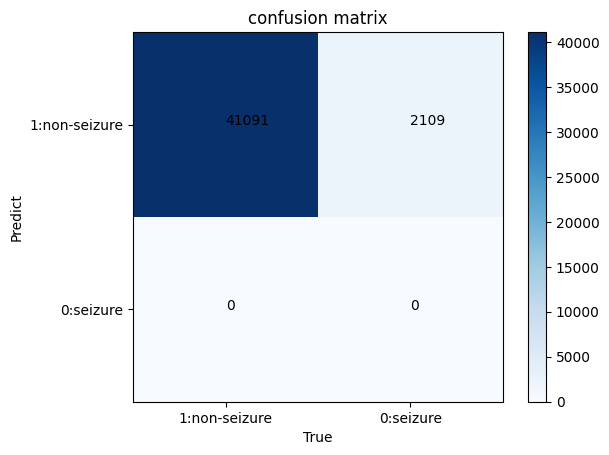

In [ ]:
print(classification_report(ones, y_pred, target_names=hypers.labels))
utils.confusion_matrix(ones, y_pred)

## 4. vizualize original & labels & predictions
```
original: black
labels: red
predictions: blue
```

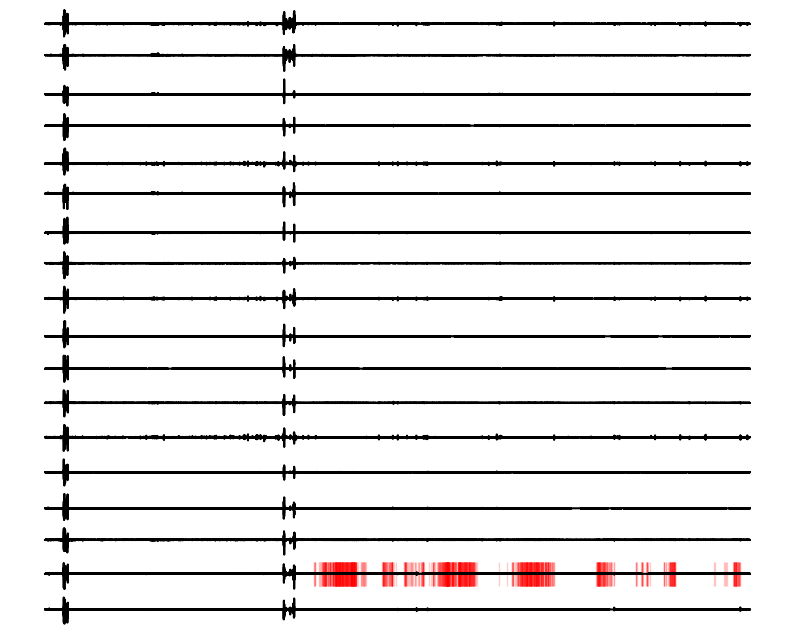

In [ ]:
fig, axes = plt.subplots(18, 1, figsize=(10, 8), sharex=True)

for id_channel in range(18):
    # original 
    axes[id_channel].plot(times, data[:, id_channel], c='k')
    axes[id_channel].axis('off')
    
# labels
for s, e in seizure_labels:
    rect_start = s/hypers.sampling_rate # 起点
    rect_end = e/hypers.sampling_rate # 终点
    rect = plt.Rectangle(xy=(rect_start, -5000), width=rect_end-rect_start, height=10000, color='red', alpha=0.2)
    axes[16].add_patch(rect) # last

# predictions
for s, e in zip(ss, ee):
    rect_start = s # 起点
    rect_end = e # 终点
    rect = plt.Rectangle(xy=(rect_start, -5000), width=rect_end-rect_start, height=10000, color='blue', alpha=0.2)
    axes[17].add_patch(rect) # last

plt.subplots_adjust(hspace=0.2)
plt.show()